# Installing librairies

In [1]:
!pip install facenet_pytorch torch-summary torchfile better-exceptions dlib future imgaug opencv-python pretrainedmodels tensorboard torch torchvision tqdm yacs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [2]:
root = '/content/drive/MyDrive/project/'

In [3]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.parallel
from torch.optim import Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
from torchvision import models, transforms

import cv2
from tqdm import tqdm, trange
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [4]:
BATCH_SIZE = 64
EPOCHS = 30
M_VALUES = [2, 4, 8, 16]

# Get data



In [5]:
class FaceDataset(Dataset):
    def __init__(self, data_dir, data_type, transform, ignore_file=None, img_size=224, age_stddev=1.0):
        assert(data_type in ("train", "valid", "test"))
        csv_path = Path(data_dir).joinpath(f"gt_avg_{data_type}.csv")
        img_dir = Path(data_dir).joinpath(data_type)

        self.transform = transform
        self.img_size = img_size
        self.age_stddev = age_stddev

        self.get_path = False

        self.x = []
        self.y = []
        self.std = []
        df = pd.read_csv(str(csv_path))
        ignore_img_names = list(pd.read_csv(str(ignore_file))["img_name"].values) if ignore_file else []

        for _, row in df.iterrows():
            img_name = row["file_name"]

            if img_name in ignore_img_names:
                continue

            img_path = img_dir.joinpath(img_name + "_face.jpg")
            assert(img_path.is_file())
            self.x.append(str(img_path))
            self.y.append(row["apparent_age_avg"])
            self.std.append(row["apparent_age_std"])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_path = self.x[idx]
        age = self.y[idx]

        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))

        if self.get_path: return torch.from_numpy(img.astype(np.float32)/255).permute(2, 0, 1), np.clip(round(age), 0, 100).astype(np.float32), img_path
        return self.transform(torch.from_numpy(img.astype(np.float32)/255).permute(2, 0, 1)), np.clip(round(age), 0, 100).astype(np.float32)


In [6]:
#@title Load data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
invTrans = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
])
test_dataset  = FaceDataset(root + "appa-real-release", "valid", normalize, root+'ignore_list.csv',img_size=224)
train_dataset = FaceDataset(root + "appa-real-release", "test" , normalize, root+'ignore_list.csv',img_size=224)

print('Normalize ? ->', torch.mean(train_dataset[0][0]))
print("Test dataset len: {}".format(len(test_dataset)))
print("Train dataset len: {}".format(len(train_dataset)))

Normalize ? -> tensor(0.0854)
Test dataset len: 1500
Train dataset len: 1978


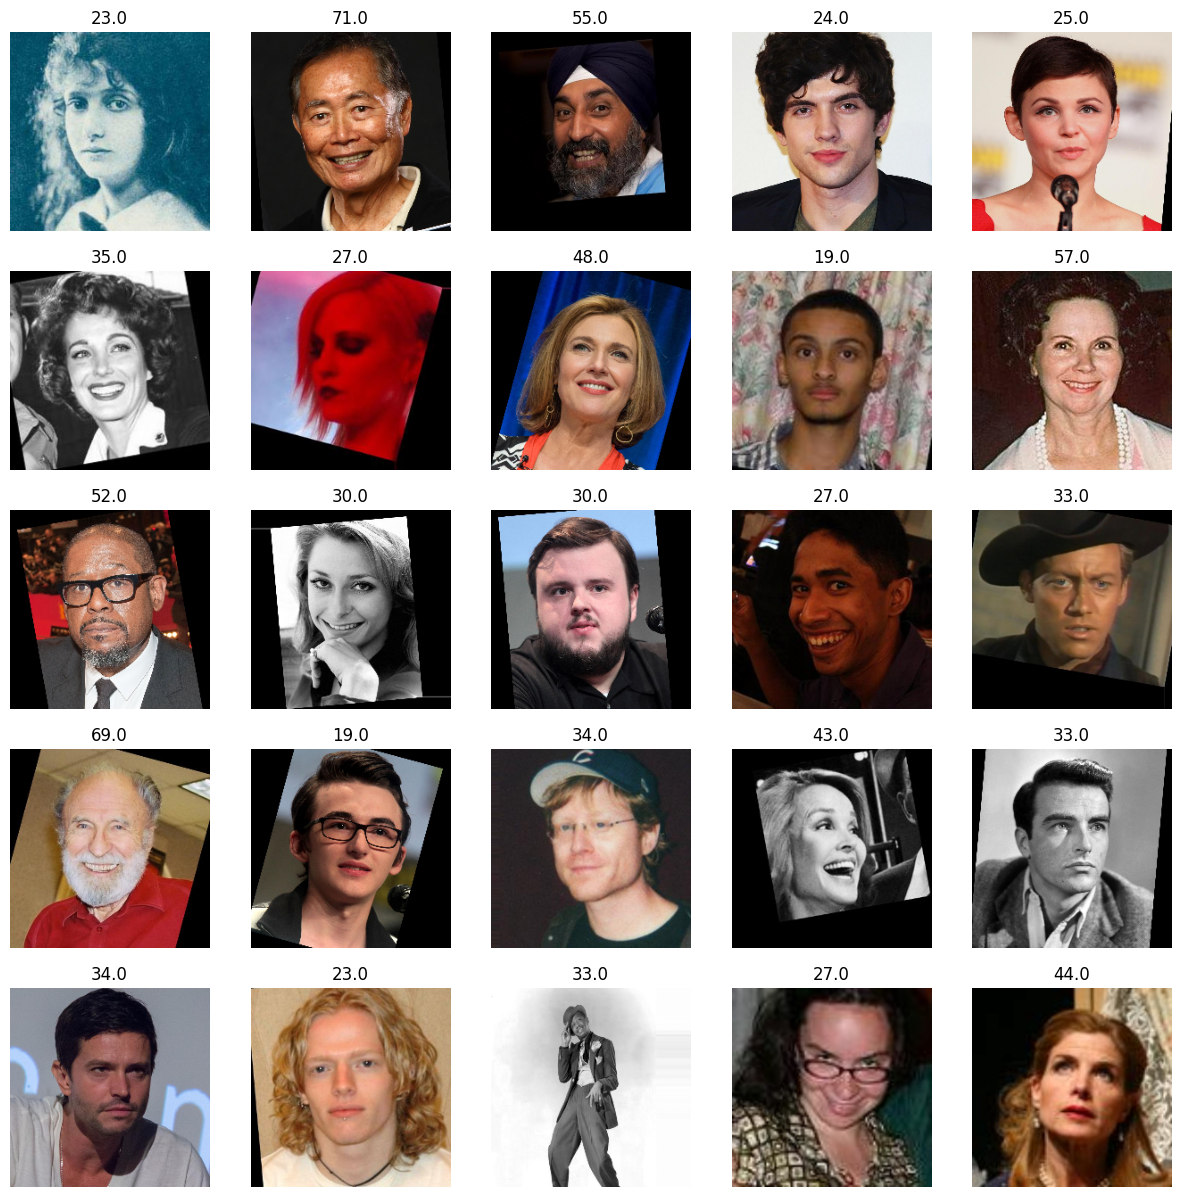

In [7]:
%matplotlib inline
plt.figure(figsize=(15,15))
for i, element in enumerate(train_dataset, 1):
    plt.subplot(5, 5, i)
    plt.imshow(invTrans(element[0]).permute(1,2,0))
    plt.title(element[1])
    plt.axis('off')
    if i > 24:
        break
plt.show()

# Feature extraction

In [8]:
def precompute_features(dataset, model, split='valid'):
    if os.path.isfile(root + f'resnet{split}_features.pkl'):
        print('Extracting from saved')
        with open(root + f'{split}_features.pkl', 'rb') as f:
            data = pickle.load(f)
    else:
        print('Computing features')

        model.to(device)
        model = torch.nn.DataParallel(model)
        model.eval()

        cumulative_outputs = []
        cumulative_targets = []

        dataset.get_path = False
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

        with torch.no_grad():
            for inputs, targets in tqdm(dataloader):
                cumulative_outputs.append(model(normalize(inputs.to(device))).detach().cpu())
                cumulative_targets.append(targets.detach().cpu())


        data = (torch.cat(cumulative_outputs, dim=0), torch.cat(cumulative_targets, dim=0))

        with open(root + f'resnet{split}_features.pkl', 'wb') as f:
            pickle.dump(data, f)

    return TensorDataset(data[0], data[1])

In [9]:
from facenet_pytorch import InceptionResnetV1

# For a model pretrained on VGGFace2
model = InceptionResnetV1(pretrained='vggface2').eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [25]:
import pickle

# Open the pickle file in binary read mode
with open('valid_features.pkl', 'rb') as f:
    # Load the object from the pickle file
    precomputed_test_dataset = pickle.load(f)
    precomputed_test_dataset=TensorDataset(precomputed_test_dataset[0],precomputed_test_dataset[1])

In [26]:
with open('test_features.pkl', 'rb') as f:
    # Load the object from the pickle file
    precomputed_train_dataset = pickle.load(f)
    precomputed_train_dataset=TensorDataset(precomputed_train_dataset[0],precomputed_train_dataset[1])

In [13]:
print(dataset1[0].shape)

torch.Size([1978, 512])


In [27]:
#precomputed_train_dataset = precompute_features(train_dataset, model,'test')
#precomputed_test_dataset = precompute_features(test_dataset, model, 'valid')

train_dataloader = torch.utils.data.DataLoader(precomputed_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(precomputed_test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
#precomputed_test_dataset = precompute_model(test_dataset, model,'valid')
# test_dataloader = torch.utils.data.DataLoader(test_dataset2, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# with open(root + 'resnet_features.pkl', 'wb') as f:
#     pickle.dump(precomputed_train_dataset, f)

# Train model

In [32]:
import torch.nn.init as init

input_size=4608
output_size=1

class MLP(nn.Module):
    def __init__(self, width, depth, input=input_size, output=output_size, bias=True,dropout=False):
        super(MLP, self).__init__()

        self.depth = depth

        self.layers = nn.Sequential()
        if dropout:
            self.layers.append(nn.Dropout(p=0.2))
        self.layers.append(nn.Linear(input, width))
        self.layers.append(nn.ReLU())
        for i in range(depth-1):
            if dropout:
                self.layers.append(nn.Dropout(p=0.2))
            self.layers.append(nn.Linear(width, width, bias=bias))
            self.layers.append(nn.ReLU())

        if dropout:
                self.layers.append(nn.Dropout(p=0.2))
        self.layers.append(nn.Linear(width, output))

        self.layers2 = nn.Sequential()
        self.layers2.append(nn.Linear(input, width))
        self.layers2.append(nn.ReLU())
        for i in range(depth-1):
            self.layers2.append(nn.Linear(width, width, bias=bias))
            self.layers2.append(nn.ReLU())
        self.layers2.append(nn.Linear(width, output))

    def forward(self, x):
        res=self.layers(x.view(x.size(0), -1))
        var=self.layers2(x.view(x.size(0), -1))
        return res,var

    def init_weight(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.normal_(module.weight, mean=0, std=1.e-3)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

In [29]:
class L2Gauss(nn.Module):
    def __init__(self):
        super(L2Gauss, self).__init__()

    def forward(self, means, log_vars, targets):
        return torch.mean(torch.exp(-log_vars)*torch.pow(targets - means, 2) + log_vars)
class RMSE(nn.Module):
    def __init__(self):
        super(RMSE, self).__init__()

    def forward(self, means, targets):
        return torch.sqrt(torch.mean(torch.pow(targets - means, 2)))


In [ ]:
# !rm -rf /content/drive/MyDrive/project/evaluating_bdl/training_logs

In [49]:
matplotlib.use("Agg")

def train(model_class, M, root, train_loader, val_loader, num_steps=1, method='ensembling', log_every=1, save_pred_every=1, quiet=False,dropout=False):

    snapshot_dir_base = root + f"evaluating_bdl/training_logs/{method}_{M}"

    weight_decay = 0.0005

    for i in range(M):

        model = model_class(256,1,512,1,dropout=dropout)
        model.init_weight()
        model = model.to(device)
        model.train()

        snapshot_dir = f'{snapshot_dir_base}_{i}/'
        if not os.path.exists(snapshot_dir):
            os.makedirs(snapshot_dir)

        learning_rate = .004
        optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        criterion = L2Gauss()
        rmse_criterion = RMSE()

        train_losses = []
        train_rmses = []
        val_losses = []
        val_rmses = []


        for i_iter in range(num_steps):
            batch_train_losses = []
            batch_train_rmses = []

            for imgs, targets in train_loader:
                imgs,targets = imgs.to(device),targets.to(device) # (shape: (batch_size))

                means, log_vars = model(imgs) # (both of shape: (batch_size))

                loss = criterion(means, log_vars, targets.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                rmse = rmse_criterion(means, targets.unsqueeze(1))

                batch_train_losses.append(loss.data.cpu().numpy())
                batch_train_rmses.append(rmse.data.cpu().numpy())

            if (i_iter % save_pred_every == 0) and (i_iter > 0):
                train_loss = np.mean(batch_train_losses)
                train_losses.append(train_loss)
                with open("%s_train_losses.pkl" % snapshot_dir, "wb") as file:
                    pickle.dump(train_losses, file)
                plt.figure(1)
                plt.plot(train_losses, "k^")
                plt.plot(train_losses, "k")
                plt.ylabel("loss")
                plt.xlabel("epoch")
                plt.title("train losses")
                plt.savefig("%s_train_losses.png" % snapshot_dir)
                plt.close(1)

                train_rmse = np.mean(batch_train_rmses)
                train_rmses.append(train_rmse)
                with open("%s_train_rmses.pkl" % snapshot_dir, "wb") as file:
                    pickle.dump(train_rmses, file)
                plt.figure(1)
                plt.plot(train_rmses, "k^")
                plt.plot(train_rmses, "k")
                plt.ylabel("rmse")
                plt.xlabel("epoch")
                plt.title("train rmses")
                plt.savefig("%s_train_rmses.png" % snapshot_dir)
                plt.close(1)

                batch_train_losses = []
                batch_train_rmses = []

            ########################################################################
            # evaluate on the val set:
            ########################################################################
            if (i_iter % save_pred_every == 0) and i_iter > 0:
                model.eval()

                batch_val_losses = []
                batch_val_rmses = []
                for i_iter_val, batch in enumerate(val_loader):
                    with torch.no_grad(): # (corresponds to setting volatile=True in all variables, this is done during inference to reduce memory consumption)
                        imgs, targets = batch
                        imgs = Variable(imgs.to(device))
                        targets = Variable(targets.to(device))

                        means, log_vars = model(imgs)

                        loss = criterion(means, log_vars, targets.unsqueeze(1))
                        rmse = rmse_criterion(means, targets.unsqueeze(1))


                    batch_val_losses.append(loss.data.cpu().numpy())
                    batch_val_rmses.append(rmse.data.cpu().numpy())

                val_loss = np.mean(batch_val_losses)
                val_losses.append(val_loss)

                with open("%s_val_losses.pkl" % snapshot_dir, "wb") as file:
                    pickle.dump(val_losses, file)
                plt.figure(1)
                plt.plot(val_losses, "k^")
                plt.plot(val_losses, "k")
                plt.ylabel("loss")
                plt.xlabel("epoch")
                plt.title("val losses")
                plt.savefig("%s_val_losses.png" % snapshot_dir)
                plt.close(1)

                val_rmse = np.mean(batch_val_rmses)
                # print ("val_rmse: %g" % val_rmse)
                val_rmses.append(val_rmse)
                with open("%s_val_rmses.pkl" % snapshot_dir, "wb") as file:
                    pickle.dump(val_rmses, file)
                plt.figure(1)
                plt.plot(val_rmses, "k^")
                plt.plot(val_rmses, "k")
                plt.ylabel("rmse")
                plt.xlabel("epoch")
                plt.title("val rmses")
                plt.savefig("%sval_rmses.png" % snapshot_dir)
                plt.close(1)

                model.train()
            ########################################################################

            if not quiet and i_iter % log_every == 0 and i_iter > 0:
                print ("Epoch %d/%d, loss: %g, RMSE: %g" % (i_iter, num_steps, loss.data.cpu().numpy(), rmse.data.cpu().numpy()))

            if i_iter == num_steps-1:
                # print("saving model...")
                torch.save(model.state_dict(), snapshot_dir + "_checkpoint_" + str(num_steps) + ".pth")
    if dropout:
        return(model)


In [31]:
log_every = 5
save_pred_every = 2
for M in M_VALUES:
    print(f'Performing M={M}')
    train(MLP, M, root, train_dataloader, test_dataloader, num_steps=EPOCHS, method=f'Ensembling', log_every=log_every, save_pred_every=save_pred_every, quiet=True)

Performing M=2
Performing M=4
Performing M=8
Performing M=16


# Train History

In [36]:
#@title load params
# from tqdm import trange
# model_id = f"ensembling{M}_"
# models = []
# num_steps=10
# for i in trange(M):
#     restore_from = root + "evaluating_bdl/training_logs/%s_%d/checkpoint_%d.pth" % (model_id, i+2, 6)
#     model = MLP(256,3,512,1)
#     model = torch.nn.DataParallel(model)
#     model.load_state_dict(torch.load(restore_from))
#     model.eval()
#     models.append(model)

In [37]:
#@title Get training logs
from collections import defaultdict

def train_logs(method='Ensembling'):
    data = dict()
    data['checkpoints'] = defaultdict(list)
    data['train_losses'] = defaultdict(list)
    data['val_losses'] = defaultdict(list)
    data['train_rmses'] = defaultdict(list)
    data['val_rmses'] = defaultdict(list)
    for M in M_VALUES:
        data['checkpoints'][M].extend([f"{root}evaluating_bdl/training_logs/{method}_{M}_{i}/_checkpoint_{EPOCHS}.pth" for i in range(M)])
        data['train_losses'][M].extend([f"{root}evaluating_bdl/training_logs/{method}_{M}_{i}/_train_losses.pkl" for i in range(M)])
        data['val_losses'][M].extend([f"{root}evaluating_bdl/training_logs/{method}_{M}_{i}/_val_losses.pkl" for i in range(M)])
        data['train_rmses'][M].extend([f"{root}evaluating_bdl/training_logs/{method}_{M}_{i}/_train_rmses.pkl" for i in range(M)])
        data['val_rmses'][M].extend([f"{root}evaluating_bdl/training_logs/{method}_{M}_{i}/_val_rmses.pkl" for i in range(M)])
    return data

ensembling_data = train_logs('Ensembling')

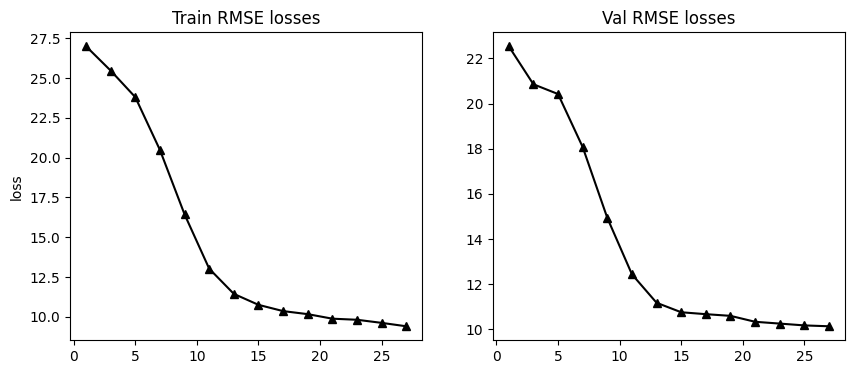

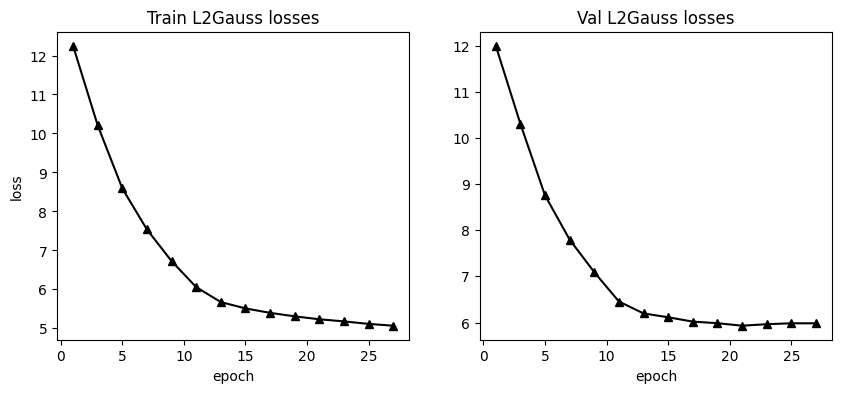

In [38]:
#@title Plot training history
%matplotlib inline
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 29, 2), pickle.load(open(ensembling_data['train_rmses'][16][3], 'rb')), "k^")
plt.plot(range(1, 29, 2), pickle.load(open(ensembling_data['train_rmses'][16][3], 'rb')), "k")
plt.ylabel("loss")
# plt.xlabel("epoch")
plt.title("Train RMSE losses")
plt.subplot(1, 2, 2)
plt.plot(range(1, 29, 2), pickle.load(open(ensembling_data['val_rmses'][16][3], 'rb')), "k^")
plt.plot(range(1, 29, 2), pickle.load(open(ensembling_data['val_rmses'][16][3], 'rb')), "k")
# plt.ylabel("loss")
# plt.xlabel("epoch")
plt.title("Val RMSE losses")
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 29, 2), pickle.load(open(ensembling_data['train_losses'][16][3], 'rb')), "k^")
plt.plot(range(1, 29, 2), pickle.load(open(ensembling_data['train_losses'][16][3], 'rb')), "k")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Train L2Gauss losses")
plt.subplot(1, 2, 2)
plt.plot(range(1, 29, 2), pickle.load(open(ensembling_data['val_losses'][16][3], 'rb')), "k^")
plt.plot(range(1, 29, 2), pickle.load(open(ensembling_data['val_losses'][16][3], 'rb')), "k")
# plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Val L2Gauss losses")
plt.show()


# Test model

Format : True | Predicted
----------------------------------------------------------------------------------------------------


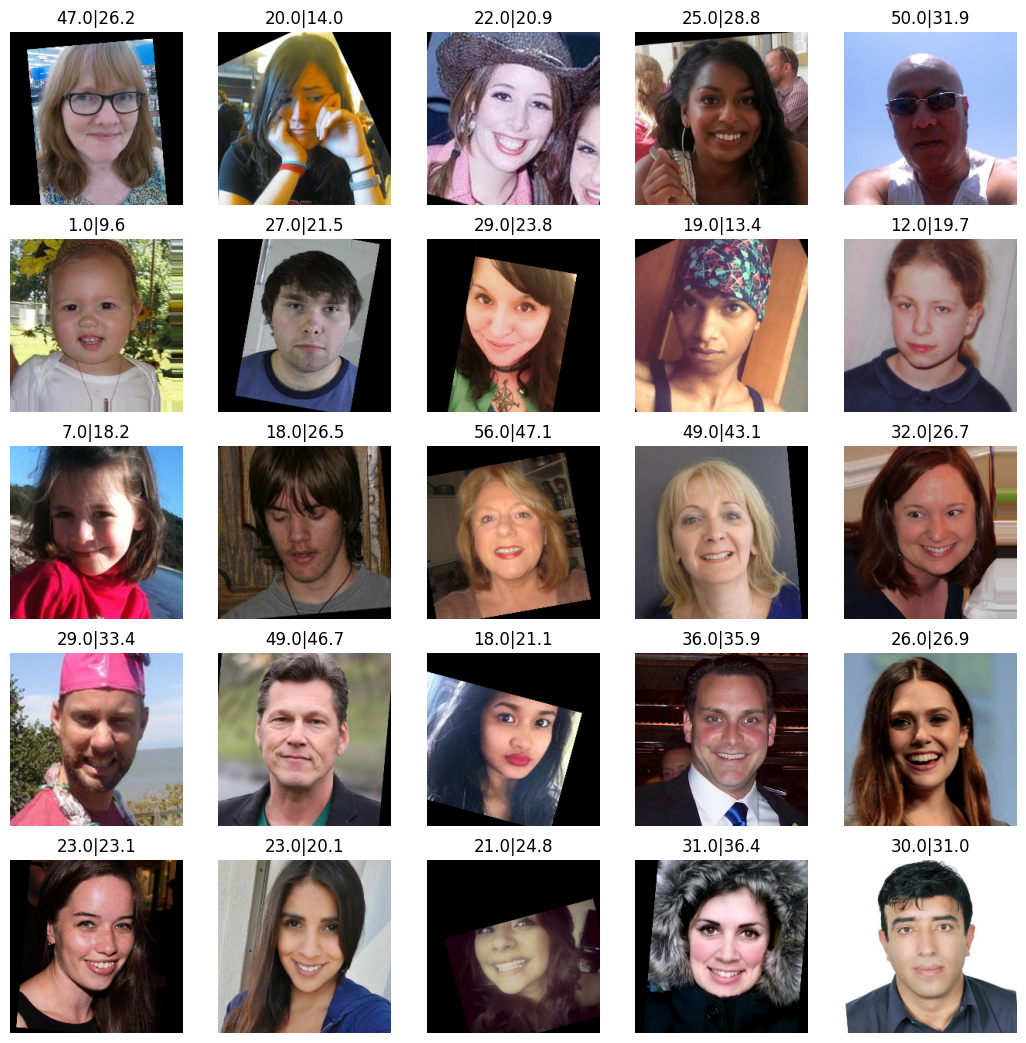

In [84]:
%matplotlib inline

print('Format : True | Predicted')
print('-'*100)
model = MLP(256, 1 , 512, 1)
model.load_state_dict(torch.load(ensembling_data['checkpoints'][16][0]))


plt.figure(figsize=(13,13))

j = 0
for img, age in test_dataloader:
    j += 1
    if j < 5: continue
    timg, tage = img[:25], age[:25]
    model.eval()
    with torch.no_grad():
        pred_ages, logvars = model(timg)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(invTrans(test_dataset[(j-1)*64+i][0]).permute(1,2,0))
        plt.title(f'{tage[i]}|{pred_ages[i].item():.1f}')
        plt.axis('off')
    break
plt.show()

# Ensembling prediction (M=16)

In [77]:
models = []
M = 16
for i in range(M):
    model = MLP(256, 1 , 512, 1)
    model.load_state_dict(torch.load(ensembling_data['checkpoints'][M][i]))
    model.eval()
    models.append(model)

def ensembling_predict(models, imgs):
    with torch.no_grad():
        means = 0.
        for m in models:
            ages, logvars = m(imgs)
            means = means + ages
        means /= len(models)
    return means



# Evaluating uncertainty with ensembling

16.0


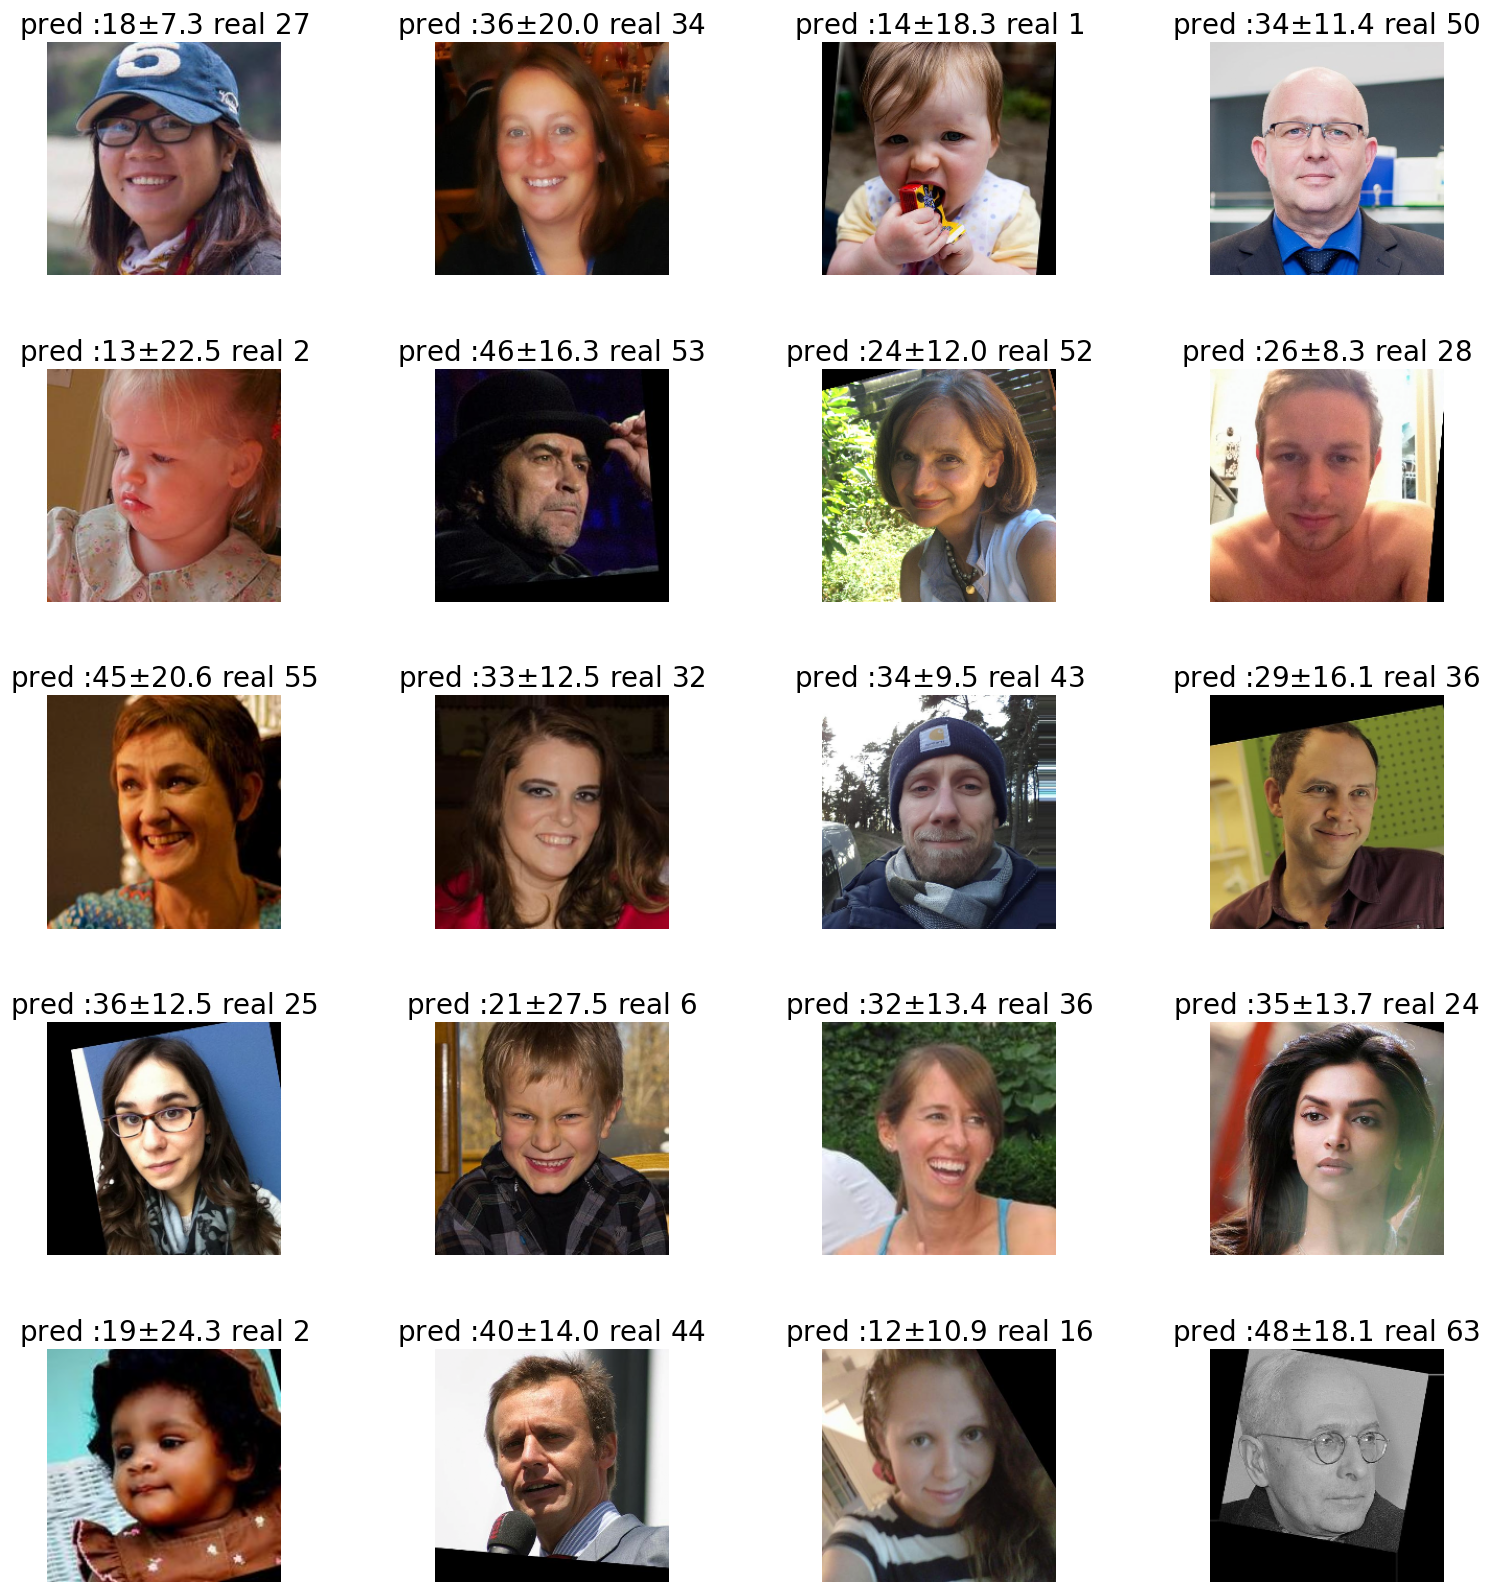

val loss: 5.94787
val rmse: 10.0783


In [85]:
M = float(len(models))
print (M)
batch_size = BATCH_SIZE

criterion = L2Gauss().cuda()
rmse_criterion = RMSE().cuda()

def eval(eval_loader):
    batch_losses = []
    batch_rmses = []
    bool=True
    for i_iter, batch in enumerate(eval_loader):
        with torch.no_grad(): # (corresponds to setting volatile=True in all variables, this is done during inference to reduce memory consumption)
            imgs, targets = batch
            imgs = Variable(imgs.cuda()) # (shape: (batch_size, h, w))
            targets = Variable(targets.cuda()) # (shape: (batch_size, h, w))

            means = []
            sigma_2_aleas = []
            for model in models:
                mean, log_var = model.to(device)(imgs) # (both of shape: (batch_size, 1, h, w))

                sigma_2_alea = torch.exp(log_var) # (sigma_alea^2) # (shape: (batch_size, 1, h, w))

                means.append(mean)
                sigma_2_aleas.append(sigma_2_alea)

            mean = torch.zeros(means[0].size()).cuda() # (shape: (batch_size, 1, h, w))
            for value in means:
                mean = mean + value/M

            sigma_2_alea = torch.zeros(means[0].size()).cuda() # (shape: (batch_size, 1, h, w)) (sigma_alea^2)
            for value in sigma_2_aleas:
                sigma_2_alea = sigma_2_alea + value/M

            sigma_2_epi = torch.zeros(means[0].size()).cuda() # (shape: (batch_size, 1, h, w)) (sigma_epi^2)
            for value in means:
                sigma_2_epi = sigma_2_epi + torch.pow(mean - value, 2)/M

            sigma_2_pred = sigma_2_alea + sigma_2_epi # (sigma_pred^2)

            loss = criterion(mean, torch.log(sigma_2_pred), targets.unsqueeze(1))
            rmse = rmse_criterion(mean, targets.unsqueeze(1))

            # print('iter = {}/{} completed, loss = {}, rmse = {}'.format(i_iter, len(test_dataset2[0])/batch_size, loss.data.cpu().numpy(), rmse.data.cpu().numpy()))

            batch_losses.append(loss.data.cpu().numpy())
            batch_rmses.append(rmse.data.cpu().numpy())
            if bool:
                plt.figure(figsize=(20,20))
                for j in range (12,32):
                    precomp_features,target=imgs[j],targets[j]
                    image=test_dataset[i_iter*BATCH_SIZE+j][0]
                    mean,log_var=model(precomp_features.unsqueeze(0))
                    plt.subplot(5, 4, j-12+1)
                    plt.subplots_adjust(hspace=0.4,wspace=0)
                    plt.imshow(invTrans(image).permute(1, 2, 0))
                    plt.title(f"pred :{mean.data.cpu().numpy()[0][0]:.0f}$\pm${2*np.sqrt(sigma_2_pred[j].item()):.1f} real {target:.0f}",fontsize=20) #, Var: {np.exp(log_var.data.cpu().numpy())}")
                    plt.axis('off')


                plt.show()
                bool=False
            # # # # # # # # # # # # # # # # # # debug START:
            # if i_iter > 0:
            #     break
            # # # # # # # # # # # # # # # # # # debug END:
    val_loss = np.mean(batch_losses)
    print ("val loss: %g" % val_loss)
    val_rmse = np.mean(batch_rmses)
    print ("val rmse: %g" % val_rmse)

eval(test_dataloader)

# Evaluating uncertainty with MC-Dropout

In [50]:
network=train(MLP, 1, root, train_dataloader, test_dataloader, num_steps=EPOCHS, method=f'Ensembling', log_every=log_every, save_pred_every=save_pred_every, quiet=True,dropout=True)

20.0


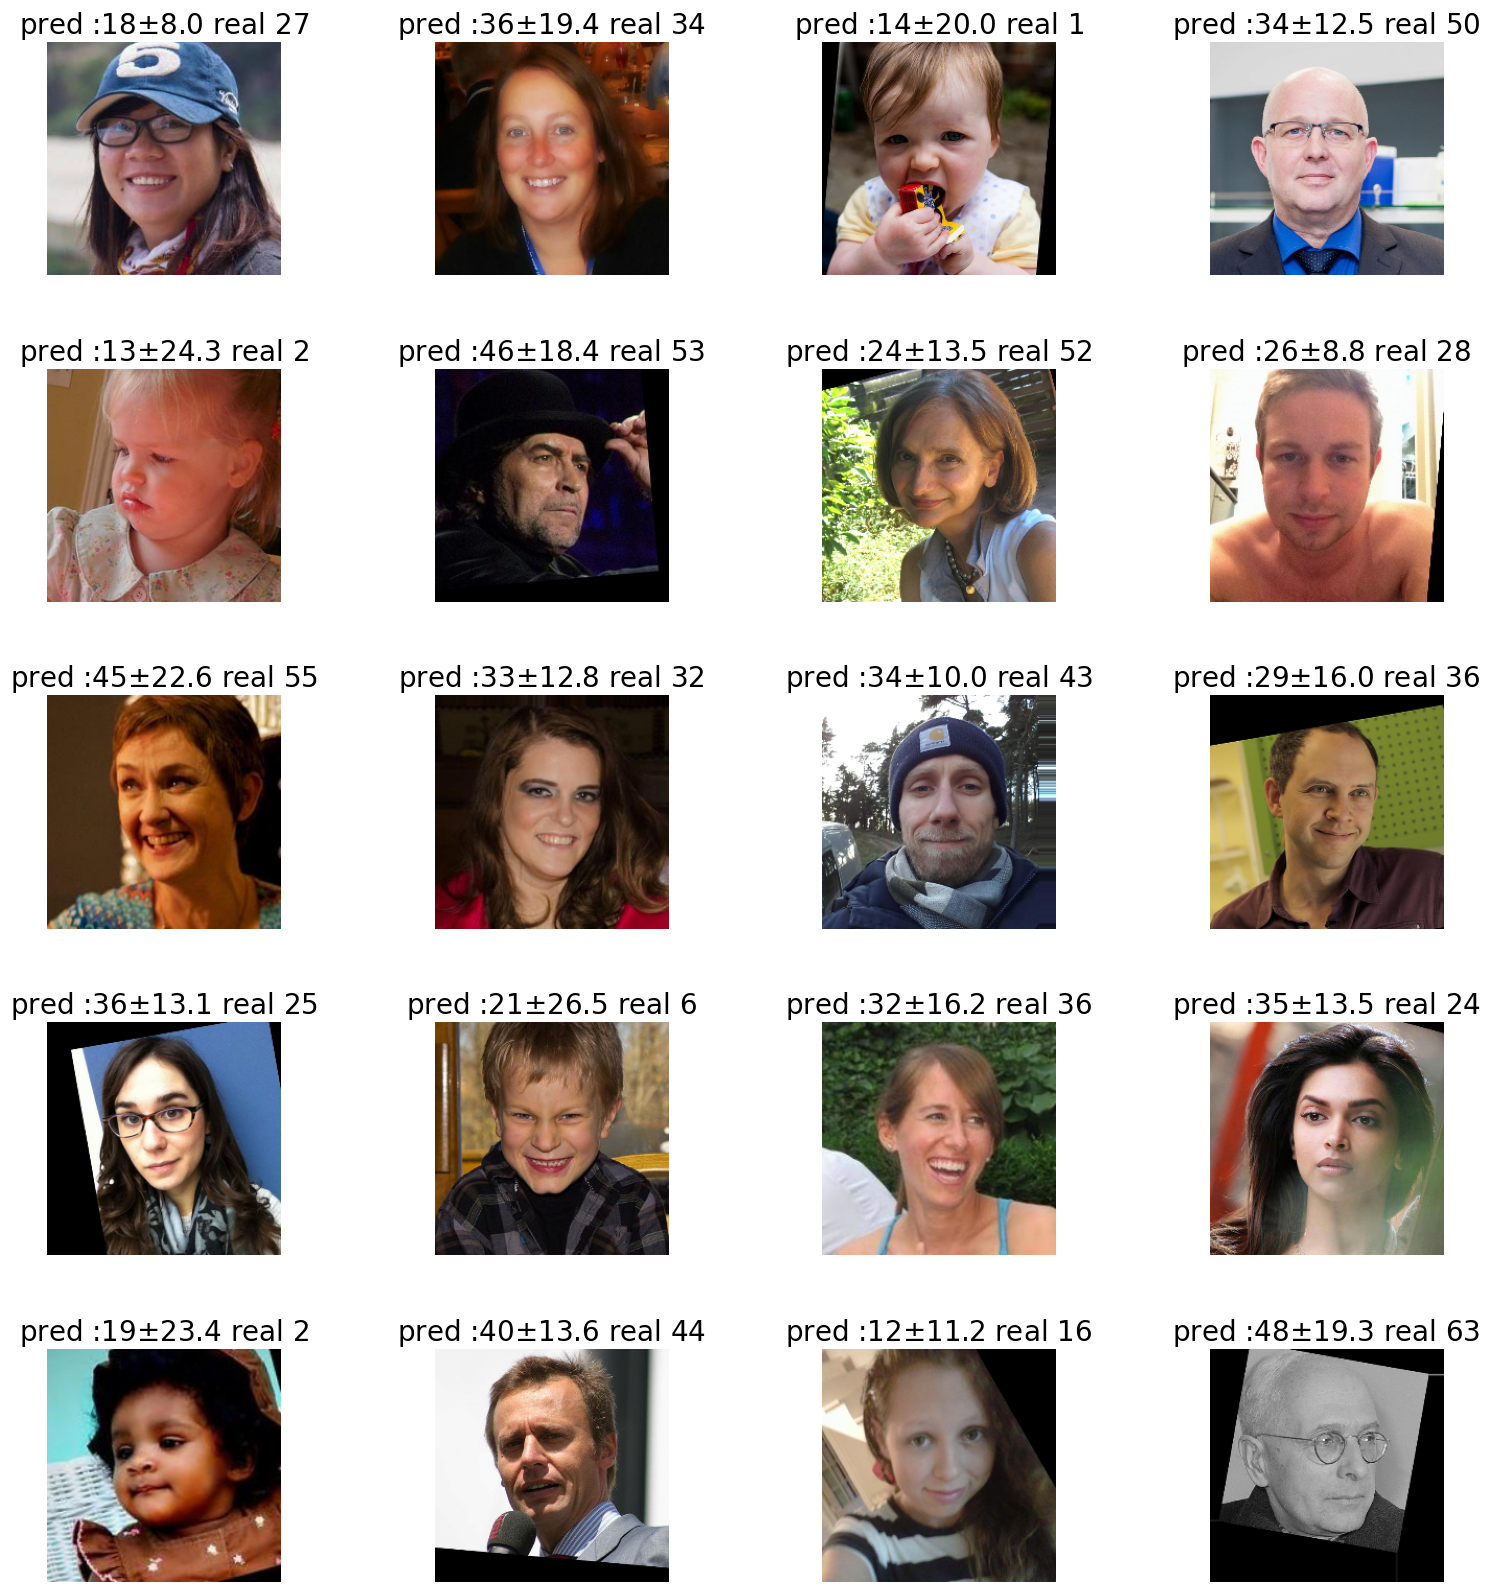

In [76]:
import torch.nn.functional as F

batch_size = 32

M = 20

max_logvar = 10

M_float = float(M)
print (M_float)

network.eval()
x_values = []
final_mean_values = []
final_sigma_tot_values = []
final_sigma_epi_values = []
final_sigma_alea_values = []

bool=True
for step, (imgs,targets) in enumerate(test_dataloader):
    imgs = Variable(imgs).cuda().unsqueeze(1) # (shape: (batch_size, 1))
    if step==0:
        sample=imgs
        sample_targ=targets
        bool=False
    means = []
    vars = []
    for i in range(M):
        outputs = network(imgs)
        mean = outputs[0] # (shape: (batch_size, ))
        var = outputs[1] # (shape: (batch_size, )) (log(sigma^2))
        var = max_logvar - F.relu(max_logvar-var)

        means.append(mean)
        vars.append(var)

    for i in range(imgs.size(0)):
        x_value = imgs[i].data.cpu().numpy()[0]

        mean_values = []
        for mean in means:
            mean_value = mean[i].data.cpu().numpy()[0]
            mean_values.append(mean_value)

        sigma_alea_values = []
        for var in vars:
            sigma_alea_value = torch.exp(var[i]).data.cpu().numpy()[0]
            sigma_alea_values.append(sigma_alea_value)

        mean_value = 0.0
        for value in mean_values:
            mean_value += value/M_float

        sigma_epi_value = 0.0
        for value in mean_values:
            sigma_epi_value += ((mean_value - value)**2)/M_float

        sigma_alea_value = 0.0
        for value in sigma_alea_values:
            sigma_alea_value += value/M_float

        sigma_tot_value = sigma_epi_value + sigma_alea_value

        x_values.append(x_value)
        final_mean_values.append(mean_value)
        final_sigma_epi_values.append(sigma_epi_value)
        final_sigma_alea_values.append(sigma_alea_value)
        final_sigma_tot_values.append(sigma_tot_value)
plt.figure(figsize=(20,20))
for j in range (12,32):
    precomp_features,target=sample[j],sample_targ[j]
    image=test_dataset[j][0]
    mean,log_var=model(precomp_features.unsqueeze(0))
    plt.subplot(5, 4, j-12+1)
    plt.subplots_adjust(hspace=0.4,wspace=0)
    plt.imshow(invTrans(image).permute(1, 2, 0))
    plt.title(f"pred :{mean.data.cpu().numpy()[0][0]:.0f}$\pm${2*np.sqrt(final_sigma_tot_values[j].item()):.1f} real {target:.0f}",fontsize=20) #, Var: {np.exp(log_var.data.cpu().numpy())}")
    plt.axis('off')
plt.show()

In [59]:
%matplotlib inline